In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
from torch.optim import AdamW

class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

In [5]:
class MemeDataset(Dataset):
    def __init__(self, data_path: str, prefix_length: int, gpt2_type: str = "IDEA-CCNL/Wenzhong-GPT2-110M", normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        self.max_boxes = 5  # 每个样本最多5个框和5条字幕

        with open(data_path, 'r', encoding='utf-8') as f:
            all_data = [json.loads(line) for line in f]

        self.prefixes = []  # 存储CLIP图像特征
        self.captions_tokens = []  # 存储5条字幕的token（列表的列表）
        self.bboxes = []  # 存储5个框（形状为 (5, 4, 2)）
        self.languages = []  # 语言标签
        self.max_seq_len = 0

        for sample in all_data:
            clip_embedding = torch.tensor(sample["image_feature"], dtype=torch.float)
            bboxes = sample["bboxes"]
            texts = sample["texts"]
            language = sample["language"]

            # 填充框到5个（不足的用全0填充）
            padded_bboxes = []
            for i in range(self.max_boxes):
                if i < len(bboxes):
                    padded_bboxes.append(bboxes[i])
                else:
                    padded_bboxes.append([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
            padded_bboxes = torch.tensor(padded_bboxes, dtype=torch.float)  # (5, 4, 2)

            # 填充字幕到5条（不足的用空字符串填充）
            padded_texts = []
            for i in range(self.max_boxes):
                if i < len(texts):
                    padded_texts.append(texts[i])
                else:
                    padded_texts.append("")
            
            # 对每条字幕编码，并记录最大长度
            caption_tokens = []
            for text in padded_texts:
                tokens = torch.tensor(self.tokenizer.encode(text), dtype=torch.int64)
                caption_tokens.append(tokens)
                self.max_seq_len = max(self.max_seq_len, tokens.shape[0])

            self.prefixes.append(clip_embedding)
            self.captions_tokens.append(caption_tokens)  # 列表，包含5条字幕的token
            self.bboxes.append(padded_bboxes)  # (5, 4, 2)
            self.languages.append(language)

        print(f"Total samples: {len(self.prefixes)}")
        print(f"Max sequence length: {self.max_seq_len}")

    def __len__(self):
        return len(self.prefixes)

    def pad_tokens(self, tokens):
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64)))
        return tokens[:self.max_seq_len]

    def __getitem__(self, idx):
        # 获取5条字幕的token并填充
        caption_tokens = [self.pad_tokens(t) for t in self.captions_tokens[idx]]  # 列表，5条字幕
        caption_tokens = torch.stack(caption_tokens)  # (5, max_seq_len)
        # print("tokens",caption_tokens.shape)
        
        # 生成字幕的mask（忽略填充部分）
        caption_mask = (caption_tokens > 0).float()  # (5, max_seq_len)
        # print(caption_mask)

        # 图像特征和语言
        prefix = self.prefixes[idx]
        if self.normalize_prefix:
            prefix = prefix / prefix.norm(2, -1)
        
        # 5个框和语言标签
        bboxes = self.bboxes[idx]  # (5, 4, 2)
        language = self.languages[idx]

        return {
            "tokens": caption_tokens,      # (5, max_seq_len)
            "mask": caption_mask,          # (5, max_seq_len)
            "prefix": prefix,             # (512,)
            "bboxes": bboxes,             # (5, 4, 2)
            "language": language           # "ch" or "en"
        }

In [6]:
# 测试函数类是否正常运行
def test_dataset(dataset_path, language_name, num_samples=3):
    print(f"\n===== 测试 {language_name} 数据集 =====")
    dataset = MemeDataset(dataset_path, prefix_length=10)
    
    # for i in range(min(num_samples, len(dataset))):
    #     sample = dataset[i]
    #     print(f"\n样本 {i + 1}:")
    #     print(f"语言: {sample['language']}")
    #     print(f"图像特征 shape: {sample['prefix'].shape}")
    #     print(f"边界框 shape: {sample['bboxes'].shape}")
        
    #     # 打印前2个框（避免输出过长）
    #     for j in range(5):
    #         print(f"框 {j + 1}: {sample['bboxes'][j].tolist()}")
        
    #     # 打印前2条字幕
    #     for j in range(5):
    #         tokens = sample['tokens'][j]
    #         text = dataset.tokenizer.decode(tokens[tokens > 0].tolist())
    #         print(tokens)
    #         print(f"字幕 {j + 1}: {text}")
    sample = dataset[0]  # 或者随机索引
    print("tokens:", sample['tokens'].shape)
    print("mask:", sample['mask'].shape)
    print("prefix:", sample['prefix'].shape)
    print("bboxes:", sample['bboxes'].shape)
    print("language:", sample['language'])
    print("token example:", sample['tokens'][0])
    print("mask example:", sample['mask'][0])
    print("bbox example:", sample['bboxes'][0])


# 测试
test_dataset("/kaggle/input/data-input/clip_bbox_data_ch_all_clear(1).jsonl", "中文")
test_dataset("/kaggle/input/data-input/clip_bbox_data_en_all_clear.jsonl", "英文")


===== 测试 中文 数据集 =====
Total samples: 2565
Max sequence length: 52
tokens: torch.Size([5, 52])
mask: torch.Size([5, 52])
prefix: torch.Size([512])
bboxes: torch.Size([5, 4, 2])
language: ch
token example: tensor([26193,   234, 32014, 12859,   239,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
mask example: tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
bbox example: tensor([[0.3183, 0.7783],
        [0.6950, 0.7783],
        [0.6950, 0.9183],
        [0.3183, 0.9183]])

===== 测试 英文 数据集

# MLP或者Transformer，生成GPT-2可以接受的伪文字矩阵（维度相同）

## BboxAwareMLP
将每个框融合进图像信息，但是是一个框一个框进行生成的，框之间没有彼此影响

In [7]:
import torch
import torch.nn as nn
from typing import Tuple, Optional

class MLP(nn.Module):
    def __init__(
        self,
        input_size: int = 512,               # CLIP特征维度 (e.g., 512)
        hidden_sizes: Tuple[int, ...]=(int(256), int(128)), # MLP隐藏层维度 (e.g., (256, 128))
        output_size: int=512,              # 输出维度 (e.g., GPT-2的输入维度)
        num_boxes: int = 5,            # 每个样本的框数量
        use_bbox: bool = True,         # 是否使用框信息
        bbox_embed_size: int = 32,     # 框嵌入维度
        act: nn.Module = nn.Tanh,      # 激活函数
    ):
        super().__init__()
        self.num_boxes = num_boxes
        self.use_bbox = use_bbox
        
        # 主MLP：处理CLIP特征
        self.clip_mlp = self._build_mlp(
            input_size, hidden_sizes, output_size, act
        )
        
        # 框特征提取MLP（如果启用）
        if self.use_bbox:
            self.bbox_mlp = nn.Sequential(
                nn.Linear(8, bbox_embed_size),  # 输入：4个角点坐标 (x1,y1,x2,y2,...)
                act(),
                nn.Linear(bbox_embed_size, bbox_embed_size)
            )
            # 融合CLIP和框特征
            self.fusion_mlp = nn.Linear(
                output_size + bbox_embed_size,
                output_size
            )

    def _build_mlp(self, input_size, hidden_sizes, output_size, act):
        layers = []
        sizes = [input_size] + list(hidden_sizes) + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(act())
        return nn.Sequential(*layers)

    def forward(
        self,
        clip_features: torch.Tensor,  # (batch_size, 512)
        bboxes: Optional[torch.Tensor] = None,  # (batch_size, num_boxes, 4, 2)
    ) -> torch.Tensor:
        # 处理CLIP特征
        clip_out = self.clip_mlp(clip_features)  # (batch_size, output_size)
        # print("clip_out",clip_out.shape)
        
        if self.use_bbox and bboxes is not None:
            # 处理框特征
            batch_size = bboxes.shape[0]
            bboxes_flat = bboxes.view(batch_size, self.num_boxes, -1)  # (batch_size, num_boxes, 8)
            bbox_embeds = self.bbox_mlp(bboxes_flat)  # (batch_size, num_boxes, bbox_embed_size)
            
            # 融合CLIP和框特征（广播CLIP特征到每个框）
            clip_out_expanded = clip_out   # (batch_size, num_boxes, output_size)
            # print("clip_out_expanded",clip_out_expanded.shape)
            fused = torch.cat([clip_out_expanded, bbox_embeds], dim=-1)
            output = self.fusion_mlp(fused)  # (batch_size, num_boxes, output_size)
        else:
            # 如果不使用框，广播CLIP特征到每个框
            output = clip_out  # 因为输入已经是 (B, N, 512)，输出就是 (B, N, output_size)

        return output  # (batch_size, num_boxes, output_size)

In [8]:
# # 测试函数是否正常运行
# mlp = MLP(
#     input_size=512,
#     hidden_sizes=(256, 128),
#     output_size=512,  # 匹配GPT-2的输入维度
#     num_boxes=5,
#     use_bbox=True,
# )

# # 假设输入数据
# batch_size = 2
# clip_features = torch.randn(batch_size, 512)  # CLIP特征
# bboxes = torch.randn(batch_size, 5, 4, 2)    # 5个框，每个框4个角点

# # 前向传播
# output = mlp(clip_features, bboxes)
# print(output.shape)  # torch.Size([2, 5, 768])

## Transformer

In [9]:
# 加入了一个把Bbox加入模型的直接用了MLP
class BboxEncoder(nn.Module):
    def __init__(self, coord_dim=8, embed_size=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(coord_dim, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size)
        )
        
    def forward(self, bboxes):
        # bboxes: (batch, num_boxes, 4, 2) -> (batch, num_boxes, embed_size)
        bboxes_flat = bboxes.view(bboxes.size(0), bboxes.size(1), -1)  # Flatten corners
        return self.mlp(bboxes_flat)

In [10]:
class MlpTransformer(nn.Module):
    def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
        super().__init__()
        out_d = out_d if out_d is not None else in_dim
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.act = act
        self.fc2 = nn.Linear(h_dim, out_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [11]:
class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)

In [12]:
class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention

In [14]:
class TransformerMapper(nn.Module):
    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, 
                 clip_length: int, num_layers: int = 8, num_boxes: int = 5):
        super().__init__()
        self.clip_length = clip_length
        self.num_boxes = num_boxes
        self.prefix_length = prefix_length  # 新增：存储prefix_length
        
        # 框坐标编码器
        self.bbox_encoder = BboxEncoder(embed_size=dim_embedding)
        
        # CLIP特征投影
        self.clip_proj = nn.Linear(dim_clip, clip_length * dim_embedding)
        
        # 可学习的prefix参数
        self.prefix_const = nn.Parameter(
            torch.randn(prefix_length, dim_embedding), 
            requires_grad=True
        )
        
        # Transformer
        self.transformer = Transformer(
            dim_self=dim_embedding,
            num_heads=8,
            num_layers=num_layers,
            dim_ref=dim_embedding,
            enc_dec=False
        )
        self.prefix_pool = nn.Linear(prefix_length * dim_embedding, 512)  # 展平后投影
        
    def forward(self, clip_features, bboxes):
        batch_size = clip_features.size(0)
        
        # 1. 编码CLIP特征
        clip_proj = self.clip_proj(clip_features)
        clip_embeds = clip_proj.view(batch_size, self.clip_length, -1)
        
        # 2. 编码框坐标
        box_embeds = self.bbox_encoder(bboxes)
        
        # 3. 融合特征
        clip_expanded = clip_embeds.unsqueeze(1).expand(-1, self.num_boxes, -1, -1)
        box_expanded = box_embeds.unsqueeze(2).expand(-1, -1, self.clip_length, -1)
        fused = clip_expanded + box_expanded
        
        # 4. 添加可学习的prefix
        prefix = self.prefix_const.unsqueeze(0).unsqueeze(1).expand(
            batch_size, self.num_boxes, -1, -1
        )
        full_input = torch.cat([fused, prefix], dim=2)
        
        # 5. 通过Transformer
        combined = full_input.view(
            batch_size * self.num_boxes, 
            self.clip_length + self.prefix_length,  # 使用self.prefix_length
            -1
        )
        out = self.transformer(combined)
        
        # 6. 输出处理
        prefix_out = out[:, self.clip_length:]  # (batch*num_boxes, prefix_length, 256)
        prefix_out = prefix_out.view(batch_size, self.num_boxes, -1)  # (batch, num_boxes, prefix_length*256)
        pooled = self.prefix_pool(prefix_out)  # (batch, num_boxes, 768)
        return pooled

In [15]:
# 测试
mapper = TransformerMapper(
    dim_clip=512,
    dim_embedding=256,
    prefix_length=10,
    clip_length=5,
    num_boxes=5
)

# 输入数据
clip_feats = torch.randn(2, 512)  # 2张图的CLIP特征
bboxes = torch.randn(2, 5, 4, 2)  # 每张图5个框

# 前向传播
output = mapper(clip_feats, bboxes)
print(output.shape)  # torch.Size([2, 5, 10, 256])

torch.Size([2, 5, 512])


# GPT-2生成字幕

In [16]:
class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
            labels: Optional[torch.Tensor] = None, bboxes: Optional[torch.Tensor] = None):
        # tokens shape: (B, 5, T)
        # prefix shape: (B, 512) 或者 (B, 5, 512) — 如果是 (B, 512)，需要复制5份
        
        B, N, T = tokens.shape
        assert N == 5, "这里默认每个样本有5条caption"
    
        # 如果 prefix 是 (B, 512)，复制成 (B, 5, 512)
        if prefix.dim() == 2:  # (B, prefix_dim)
            prefix = prefix.unsqueeze(1).expand(-1, N, -1).contiguous()
    
        # print("prefix after expand:", prefix.shape)  # 应该是 (B, 5, 512)
        
        ## 做到这里了，前面的prefix和token都是[40,5,512]。后面还需要改一改
        # 把 tokens 和 prefix 都展平成 (B*N, *)
        tokens = tokens.view(B * N, -1)
        # print(tokens.shape)
        if mask is not None:
            mask = mask.view(B * N, -1)
            # print(mask.shape)
        # prefix = prefix.view(B * N, -1)
        # print("prefix",prefix.shape)
    
        # 文本 embedding
        embedding_text = self.gpt.transformer.wte(tokens)  # (B*N, T, embedding_dim)
        # print("embedding_text",embedding_text.shape)
    
        # prefix 经过线性变换并 reshape 成 (B*N, prefix_length, gpt_embedding_size)
        # print("clip_project",self.clip_project(prefix).shape)
        prefix_projections = self.clip_project(prefix, bboxes).view(B * N, self.prefix_length, self.gpt_embedding_size)
        # print("prefix_projections",prefix_projections.shape)
        # 拼接 prefix embedding 和文本 embedding
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
    
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        
        # 假设你希望 prefix 的 attention mask 是全 1（可以被注意）
        prefix_mask = torch.ones(prefix_projections.size()[:-1], dtype=mask.dtype).to(mask.device)  # shape: [200, 10]
        
        # 拼接 prefix 和 token 的 mask
        full_mask = torch.cat((prefix_mask, mask), dim=1)  # shape: [200, 10 + 52] = [200, 62]

        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=full_mask)
        return out


    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('IDEA-CCNL/Wenzhong-GPT2-110M')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP(
                input_size=prefix_size,
                hidden_sizes=[(self.gpt_embedding_size * prefix_length) // 2],
                output_size=self.gpt_embedding_size * prefix_length
            )
            
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [22]:
import os
import matplotlib.pyplot as plt

def train(dataset: MemeDataset, model: ClipCaptionModel, args,
          lr: float = 1e-4, warmup_steps: int = 1000, output_dir: str = ".", output_prefix: str = ""):
    all_losses = []          # 记录所有batch loss
    epoch_losses = []        # 记录每个epoch的平均loss
    device = torch.device('cuda:0')
    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        batch_losses = []   # 每个epoch开始清空
        for idx, batch in enumerate(train_dataloader):
            tokens = batch['tokens']
            # print("tokens",tokens.shape)
            mask = batch['mask']
            # print("mask",mask.shape)
            prefix = batch['prefix']
            # print(prefix.shape)
            bboxes = batch['bboxes']
            language = batch['language']
            # 下面写训练逻辑

            model.zero_grad()
        
            # tokens: (B, 5, T), mask: (B, 5, T), prefix: (B, 5, prefix_size)
            tokens, mask, prefix, bboxes = (
            tokens.to(device),
            mask.to(device),
            prefix.to(device, dtype=torch.float32),
            bboxes.to(device, dtype=torch.float32), )
            outputs = model(tokens, prefix, mask, bboxes=bboxes)
            logits = outputs.logits  # shape: (B*5, T + prefix_len, vocab)
        
            # 只保留预测文本部分（去掉 prefix）
            logits = logits[:, model.prefix_length - 1: -1]  # 对齐 tokens
            tokens_flat = tokens.view(-1, tokens.shape[-1])  # (B*5, T)
        
            loss_all = nnf.cross_entropy(
                logits.reshape(-1, logits.shape[-1]), 
                tokens_flat.flatten(), 
                ignore_index=0, 
                reduction='none'  # 逐 token loss
            )
            loss_all = loss_all.view(tokens_flat.shape)  # (B*5, T)
            # logits 检查
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("⚠️ logits 中出现非法值，跳过该 batch")
                continue
            
            # 防止 mask.sum 为 0
            denom = mask.view(-1, mask.shape[-1]).sum(dim=1)
            denom = denom.clamp(min=1e-6)
            if idx < 5:
                print("tokens batch shape:", tokens.shape)
                print("mask non-zero tokens:", (mask > 0).sum().item())
                print("prefix batch shape:", prefix.shape)
                print("bboxes shape:", bboxes.shape)
            loss_per_caption = loss_all.sum(dim=1) / denom
            loss = loss_per_caption.view(-1, 5).mean(dim=1).mean()
            
            # loss 检查
            if torch.isnan(loss) or torch.isinf(loss):
                print("⚠️ loss 出现非法值，跳过该 batch")
                continue

            # 更新模型
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            loss_per_batch = loss.item()
            batch_losses.append(loss_per_batch)
            all_losses.append(loss_per_batch)

            progress.set_postfix({"loss": loss_per_batch})
            progress.update()

            if (idx + 1) % 10000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
            # 显存清理 START
            del tokens, mask, prefix, bboxes, outputs, logits, loss_all, loss_per_caption, loss
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            # 显存清理 END
        progress.close()
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        print(f"Epoch {epoch} average loss: {epoch_avg_loss:.4f}")

        if epoch % args.save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )

    # 训练结束画图
    plt.figure(figsize=(10,5))
    plt.plot(all_losses, label='Batch Loss')
    plt.plot(
        [i * len(train_dataloader) for i in range(len(epoch_losses))],  # x轴epoch起点
        epoch_losses, label='Epoch Average Loss', marker='o'
    )
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{output_prefix}_loss_curve.png"))
    plt.show()

    return model

Total samples: 2565
Max sequence length: 52
Train both prefix and GPT
>>> Training epoch 0


coco_prefix:   0%|          | 0/641 [00:00<?, ?it/s]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 97
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 1/641 [00:00<04:43,  2.26it/s, loss=1.35]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 105
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 2/641 [00:00<04:23,  2.43it/s, loss=2.61]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 36
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 3/641 [00:01<04:22,  2.43it/s, loss=0.687]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 67
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   1%|          | 4/641 [00:01<04:21,  2.43it/s, loss=0.654]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 59
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix: 100%|██████████| 641/641 [04:23<00:00,  2.43it/s, loss=1.12] 


Epoch 0 average loss: 0.9111
>>> Training epoch 1


coco_prefix:   0%|          | 0/641 [00:00<?, ?it/s]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 79
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 1/641 [00:00<04:32,  2.35it/s, loss=0.789]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 73
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 2/641 [00:00<04:24,  2.42it/s, loss=0.463]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 75
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 3/641 [00:01<04:21,  2.44it/s, loss=0.51] 

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 101
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   1%|          | 4/641 [00:01<04:20,  2.45it/s, loss=0.767]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 62
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix: 100%|██████████| 641/641 [04:22<00:00,  2.45it/s, loss=1.08] 


Epoch 1 average loss: 0.8171
>>> Training epoch 2


coco_prefix:   0%|          | 0/641 [00:00<?, ?it/s]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 89
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 1/641 [00:00<04:28,  2.39it/s, loss=0.599]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 66
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 2/641 [00:00<04:22,  2.43it/s, loss=0.509]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 63
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 3/641 [00:01<04:20,  2.45it/s, loss=1.06] 

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 71
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   1%|          | 4/641 [00:01<04:19,  2.45it/s, loss=0.714]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 88
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix: 100%|██████████| 641/641 [04:22<00:00,  2.45it/s, loss=0.832]


Epoch 2 average loss: 0.6583
>>> Training epoch 3


coco_prefix:   0%|          | 0/641 [00:00<?, ?it/s]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 67
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 1/641 [00:00<04:29,  2.38it/s, loss=0.282]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 67
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 2/641 [00:00<04:24,  2.42it/s, loss=1.05] 

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 75
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 3/641 [00:01<04:22,  2.43it/s, loss=1.34]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 43
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   1%|          | 4/641 [00:01<04:20,  2.45it/s, loss=0.27]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 88
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix: 100%|██████████| 641/641 [04:22<00:00,  2.44it/s, loss=0.457]


Epoch 3 average loss: 0.5188
>>> Training epoch 4


coco_prefix:   0%|          | 0/641 [00:00<?, ?it/s]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 88
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 1/641 [00:00<04:25,  2.41it/s, loss=0.298]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 71
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 2/641 [00:00<04:23,  2.43it/s, loss=0.343]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 46
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   0%|          | 3/641 [00:01<04:21,  2.44it/s, loss=0.47] 

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 35
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix:   1%|          | 4/641 [00:01<04:19,  2.45it/s, loss=0.272]

tokens batch shape: torch.Size([4, 5, 52])
mask non-zero tokens: 68
prefix batch shape: torch.Size([4, 512])
bboxes shape: torch.Size([4, 5, 4, 2])


coco_prefix: 100%|██████████| 641/641 [04:22<00:00,  2.44it/s, loss=0.396]


Epoch 4 average loss: 0.4201


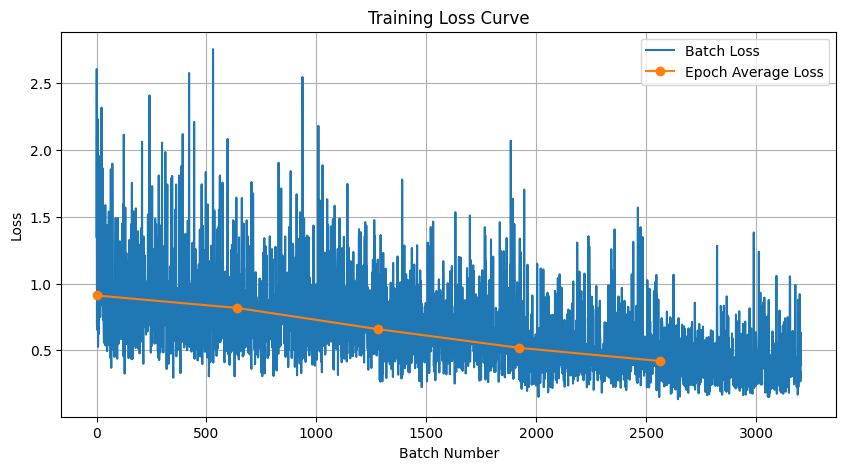

In [24]:
sys.argv = [sys.argv[0]]
parser = argparse.ArgumentParser()
parser.add_argument('--data', default='/kaggle/input/data-input/clip_bbox_data_ch_all_clear(1).jsonl')
parser.add_argument('--out_dir', default='/kaggle/working/checkpoints')
parser.add_argument('--prefix', default='coco_prefix', help='prefix for saved filenames')
parser.add_argument('--epochs', type=int, default=5)
parser.add_argument('--save_every', type=int, default=1)
parser.add_argument('--prefix_length', type=int, default=10)
parser.add_argument('--prefix_length_clip', type=int, default=10)
parser.add_argument('--bs', type=int, default=4)
parser.add_argument('--only_prefix', dest='only_prefix', action='store_true')
parser.add_argument('--mapping_type', type=str, default='mlp', help='mlp/transformer')
parser.add_argument('--num_layers', type=int, default=8)
parser.add_argument('--is_rn', dest='is_rn', action='store_true')
parser.add_argument('--normalize_prefix', dest='normalize_prefix', action='store_true')
args = parser.parse_args()
prefix_length = args.prefix_length
dataset = MemeDataset(args.data, prefix_length, normalize_prefix=args.normalize_prefix)
prefix_dim = 640 if args.is_rn else 512
args.mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}[args.mapping_type]
if args.only_prefix:
    model = ClipCaptionPrefix(prefix_length, clip_length=args.prefix_length_clip, prefix_size=prefix_dim,
                              num_layers=args.num_layers, mapping_type=args.mapping_type)
    print("Train only prefix")
else:
    model = ClipCaptionModel(prefix_length, clip_length=args.prefix_length_clip, prefix_size=prefix_dim,
                              num_layers=args.num_layers, mapping_type=args.mapping_type)
    print("Train both prefix and GPT")
    sys.stdout.flush()
# main函数内，调用train后，添加保存代码，修改如下：
trained_model = train(dataset, model, args, output_dir=args.out_dir, output_prefix=args.prefix)
torch.save(
    trained_model.state_dict(),
    os.path.join("final_main.pt"),
)

In [27]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink

/kaggle/working
['final_main.pt', '.virtual_documents', 'checkpoints', '.ipynb_checkpoints']


In [28]:
FileLink('final_main.pt')

/kaggle/working/final_main.pt